### **Imports and utils**

Importing libraies

In [6]:
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
from keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, Concatenate, UpSampling2D
from keras.models import Model
from keras.models import load_model
from keras.optimizers import Adam
import tensorflow as tf
from keras import backend as K

Utils functions

In [7]:
def read_header_and_data(file_path, idx):
    with fits.open(file_path) as hdu:
        header = hdu[idx].header
        data = hdu[idx].data

        return header, data

def show_image(image_data, cmap='gist_gray'):
    plt.figure()
    plt.imshow(image_data, cmap=cmap)
    plt.colorbar()

def normalize(array):
    arr_max = np.max(array)
    arr_min = np.min(array)

    arr_normalized = (array - arr_min) / (arr_max - arr_min)

    return arr_normalized

def normalize_list(list_arrays):
    list_arrays_normalized = [normalize(array) for array in list_arrays]
    list_arrays_normalized = np.array(list_arrays_normalized)

    return list_arrays_normalized

def compute_mean_img(img_dataset):
    n = img_dataset.shape[0]
    mean_img = np.sum(img_dataset, axis=0, dtype=np.float32) / n

    return mean_img

def mean_subtract_list(img_dataset):
    mean_img = compute_mean_img(img_dataset)

    return img_dataset - mean_img

def psf_to_otf_np(ker, size):
    psf = np.zeros(size, dtype=np.float64)

    center_x = (ker.shape[0] + 1) // 2
    center_y = (ker.shape[1] + 1) // 2

    psf[:center_x, :center_y] = ker[center_x:, center_y:]
    psf[:center_x, -center_y:] = ker[center_x:, :center_y]
    psf[-center_x:, :center_y] = ker[:center_x, center_y:]
    psf[-center_x:, -center_y:] = ker[:center_x, :center_y]

    otf = psf

    return otf

def psf_to_oft_list(ker_list):
    list_oft = [psf_to_otf_np(ker, ker.shape) for ker in ker_list]
    list_oft = np.array(list_oft)

    return list_oft

def cvt_tensor_list(list_arrays):
    list_tensors = [tf.convert_to_tensor(array) for array in list_arrays]
    list_tensors = np.array(list_tensors)

    return list_tensors

### **Denoising**

Processing and spliting denoising data

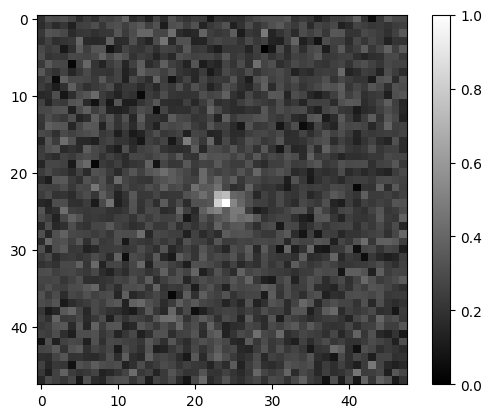

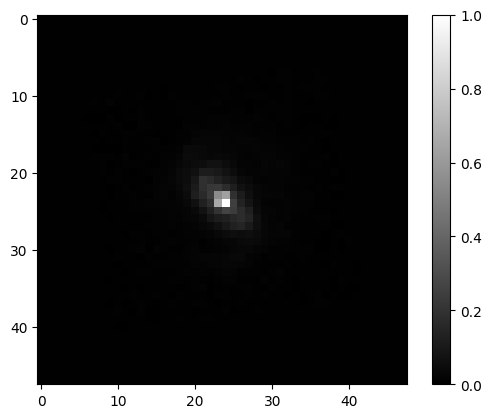

In [8]:
image_file_path = 'outputs/output_denoising_snr40_10k.fits'
img_head, img_data = read_header_and_data(image_file_path, 0)

#img_data = np.random.permutation(img_data)
img_data = normalize_list(img_data)
img_size = img_data[0].shape[0]
num_total = len(img_data)
train_split = 0.7
train_idx = int(num_total * train_split)

img_data = np.array([np.reshape(img, (img_size, img_size, 1)) for img in img_data])
img_shape = img_data[0].shape

# Spliting training and testing
train = img_data[0:train_idx]
#train = mean_subtract_list(train)
train_x = train[[i for i in range(0, len(train), 2)]]
train_y = train[[i for i in range(1, len(train), 2)]]

test = img_data[train_idx:num_total]
#test = mean_subtract_list(test)
test_x = test[[i for i in range(0, len(test), 2)]]
test_y = test[[i for i in range(1, len(test), 2)]]

idx = 0
show_image(test_x[idx])
show_image(test_y[idx])

1/1 [==============================] - 0s 258ms/step


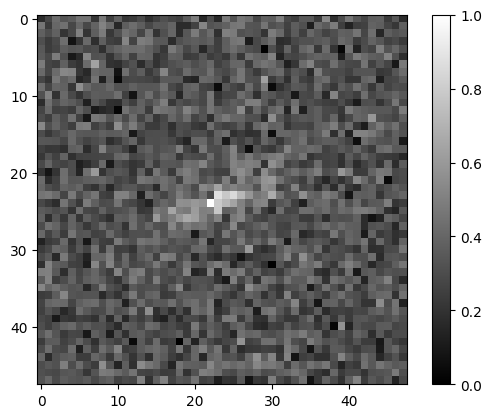

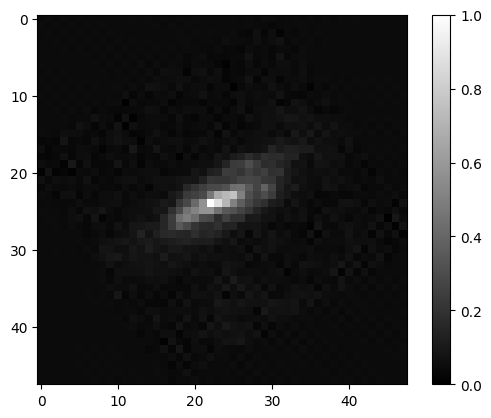

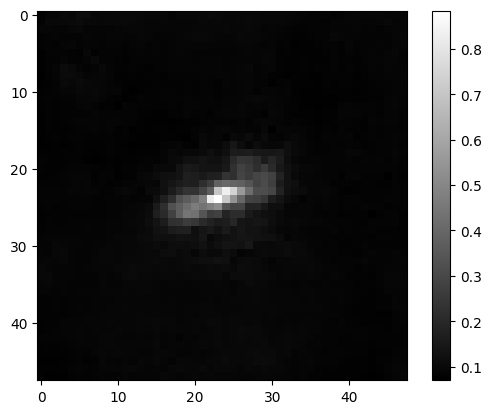

In [10]:
denoiser_100 = load_model('models/resunet_100snr_mse_5_50.keras')
denoiser_40 = load_model('models/resunet_40snr.keras')
denoiser_multi = load_model('models/resunet_mul_snr.keras')
denoiser_tiny = load_model('models/resunet_tiny_snr.keras')

img = train_x[0]
img = np.reshape(img, (1, 48, 48, 1))
img = np.reshape(denoiser_40.predict(img), (48, 48, 1))

show_image(train_x[0])
show_image(train_y[0])
show_image(img)

ResUNet

In [3]:
# from paper Qian, H. et al 2022

def resnet_block(x, x_shortcut, num_filters, kernel_size=3):
    # Main block
    rb = Conv2D(num_filters, kernel_size, padding='same')(x)
    rb = BatchNormalization()(rb)
    rb = Activation('relu')(rb)
    rb = Conv2D(num_filters, kernel_size, padding='same')(rb)

    # Add
    x_shortcut = Conv2D(num_filters, kernel_size=1, padding='same')(x_shortcut)
    #x_shortcut = BatchNormalization()(x_shortcut)
    rb = Add()([x_shortcut, rb])

    return rb

def upsample_concatenate(x, skip):
    x = UpSampling2D((2, 2))(x)

    return Concatenate()([x, skip])

def resUnet(input_shape=(48, 48, 1), num_filters=64, num_resnetblocks=4, kernel_size=3): # change filters dynamically and check blocks
    inputs = Input(input_shape)

    # Encoder
    x = inputs
    skip_connections = []
    for i in range(num_resnetblocks):
        if not i == 0: x = BatchNormalization()(x)
        x = resnet_block(x, x, num_filters, kernel_size)
        if not i == num_resnetblocks-1:
            skip_connections += [x] # copy maybe
            x = Conv2D(num_filters, kernel_size, strides=2, padding='same')(x)

    # Transition
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters * 2, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters * 2, kernel_size, padding='same')(x)

    # Decoder
    for i in range(num_resnetblocks-1):
        skip = skip_connections.pop()
        x = upsample_concatenate(x, skip)
        x_shortcut = x
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = resnet_block(x, x_shortcut, num_filters, kernel_size)

    x = BatchNormalization()(x)
    x = Conv2D(num_filters, kernel_size, padding='same')(x)

    outputs = Conv2D(1, 1, activation='sigmoid')(x)
    network = Model(inputs, outputs)

    return network

In [7]:
resunet_model = resUnet(input_shape=img_shape, num_filters=64, num_resnetblocks=4, kernel_size=3)
resunet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 48, 48, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 48, 48, 64)           640       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 48, 48, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 48, 48, 64)           0         ['batch_normalization[0][0

In [48]:
resunet_model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mse'])

batch_size = 5
epochs = 10
history = resunet_model.fit(train_x, train_y, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(test_x, test_y))

Epoch 1/10
1400/1400 [==============================] - 213s 149ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 2/10
1400/1400 [==============================] - 209s 149ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 8.9034e-04 - val_mse: 8.9034e-04
Epoch 3/10
1400/1400 [==============================] - 193s 138ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 9.8370e-04 - val_mse: 9.8370e-04
Epoch 4/10
1400/1400 [==============================] - 168s 120ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 8.8494e-04 - val_mse: 8.8494e-04
Epoch 5/10
1400/1400 [==============================] - 175s 125ms/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0074 - val_mse: 0.0074
Epoch 6/10
1400/1400 [==============================] - 261s 186ms/step - loss: 0.0067 - mse: 0.0067 - val_loss: 0.0074 - val_mse: 0.0074
Epoch 7/10
1400/1400 [==============================] - 245s 175ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0010 - val_mse: 0.0010
Epoch 8/10

94/94 [==============================] - 2s 20ms/step


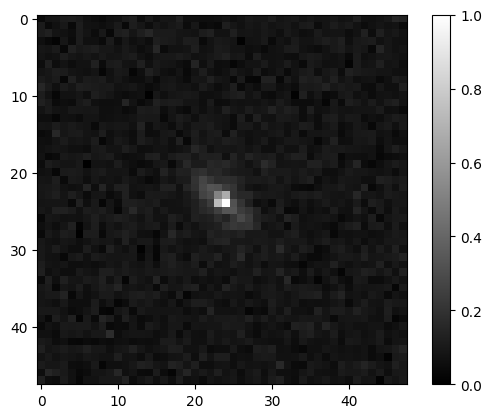

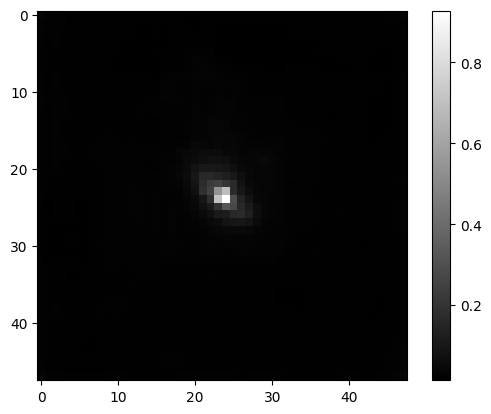

In [11]:
predictions = resunet_model.predict(test_x)
idx = 0
show_image(test_x[idx])
show_image(predictions[idx])

Saving model to file

In [49]:
resunet_model.save('resunet_100snr_debug.keras')

### **Deconvolution**

Importing images and spliting training and testing datasets

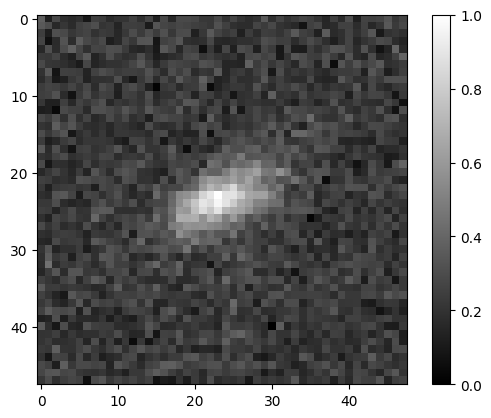

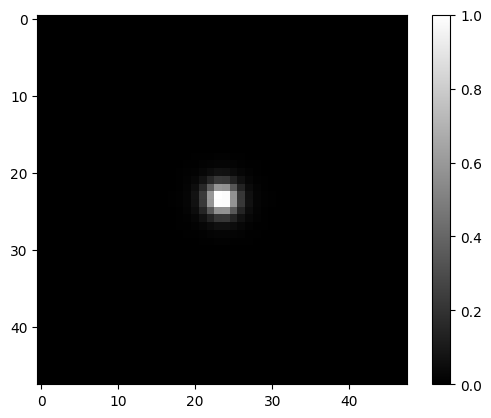

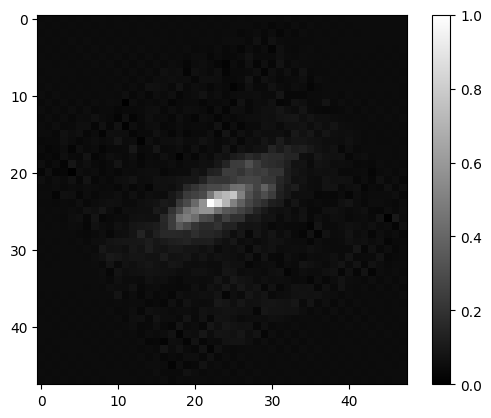

In [4]:
# Importing images
image_file_path = 'outputs/output_deconv_snr100_5k.fits'
img_head, img_data = read_header_and_data(image_file_path, 0) # img_data = [mod_img1, original_img1, mod_img2, original_img2, ...]

image_psf_file_path = 'outputs/output_deconv_snr100_5k_psf.fits'
psf_head, psf_data = read_header_and_data(image_psf_file_path, 0)

# Getting image size
img_size = img_data[0].shape[0]

# Normalizing images
img_data = normalize_list(img_data)
psf_data = normalize_list(psf_data)

# Reshaping images
img_data = np.array([np.reshape(img, (img_size, img_size, 1)) for img in img_data])
psf_data = np.array([np.reshape(psf, (img_size, img_size, 1)) for psf in psf_data])
img_shape = img_data[0].shape

# Spliting training and testing
train_split = 0.7
img_size = img_data[0].shape[0]
num_total = len(img_data)
train_idx = int(num_total * train_split)

img_train = img_data[0:train_idx]
psf_train = psf_data[0:train_idx]

img_test = img_data[train_idx:num_total]
psf_test = psf_data[train_idx:num_total]

# Image train
img_train_x = img_train[[i for i in range(0, len(img_train), 2)]]
img_train_y = img_train[[i for i in range(1, len(img_train), 2)]]

# PSF of the train images
psf_train_x = psf_train[[i for i in range(0, len(psf_train), 2)]]

# Image test
img_test_x = img_test[[i for i in range(0, len(img_test), 2)]]
img_test_y = img_test[[i for i in range(1, len(img_test), 2)]]

# PSF of the test images
psf_test_x = psf_test[[i for i in range(0, len(psf_test), 2)]]

idx = 0
show_image(img_train_x[idx])
show_image(psf_train_x[idx])
show_image(img_train_y[idx])

ADMM

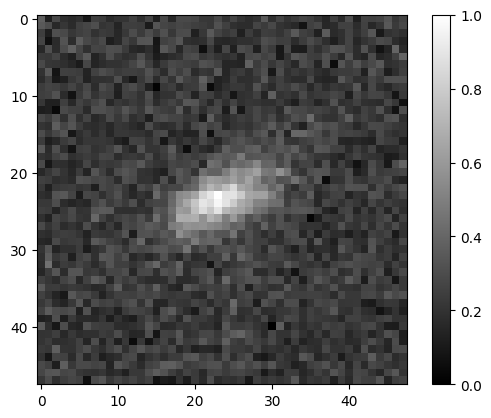

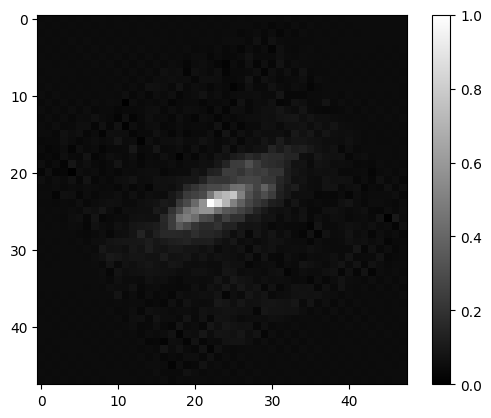

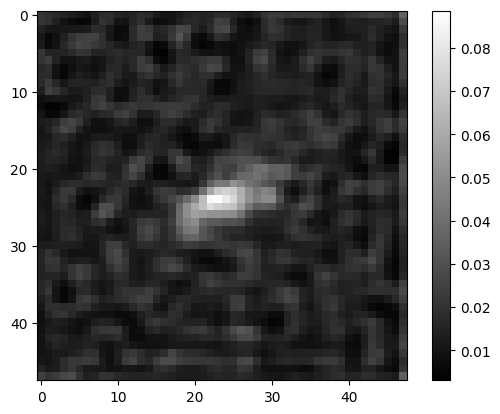

In [5]:
def generate_rho_values(start, end, n):
    rho_values = []
    step_size = (end - start) / (n - 1) if n > 1 else 0

    for i in range(n):
        rho_values.append(start + i * step_size)

    return rho_values

def compute_alpha(N, y, beta=0.33):
    return K.sum(y) / (N * beta)

def normalize(x):
    x = tf.clip_by_value(x, 0, 1)
    return x

def fft2(x):
    x_complex = tf.cast(x, dtype=tf.complex64)
    return tf.signal.fft2d(x_complex)

def ifft2(x):
    return tf.signal.ifft2d(x)

def psf_to_otf(ker, size):
    psf = K.zeros(size, dtype=K.floatx())

    center_x = (ker.shape[0] + 1) // 2
    center_y = (ker.shape[1] + 1) // 2

    psf[:center_x, :center_y].assign(ker[center_x:, center_y:])
    psf[:center_x, -center_y:].assign(ker[center_x:, :center_y])
    psf[-center_x:, :center_y].assign(ker[:center_x, center_y:])
    psf[-center_x:, -center_y:].assign(ker[:center_x, :center_y])

    otf = fft2(psf)

    return psf, otf


def unrolled_PNP_ADMM(y, h, n, denoiser):
    width, height, channels = K.int_shape(y)

    y = tf.reshape(y, (width, height))
    y = K.maximum(y, K.zeros_like(y))
    h = tf.reshape(h, (width, height))

    N = width * height
    alpha = compute_alpha(N, y)
    alpha_inv = 1/alpha

    # Initialize x with Wiener Filter
    Y = fft2(y)
    psf, H = psf_to_otf(h, K.int_shape(y))
    #H = fft2(h)
    #Ht = K.transpose(H)
    Ht_conj = tf.math.conj(H)
    H_abs_sqr = K.abs(H) ** 2
    x0 = alpha_inv * K.abs(ifft2((Ht_conj * Y) / tf.cast((alpha_inv + H_abs_sqr), dtype=tf.complex64)))
    x0 = normalize(x0)
    x = [x0]

    # Initialize other parameters
    z = tf.identity(x[0])
    v = tf.identity(y)
    u1 = K.zeros_like(x)
    u2 = K.zeros_like(y)

    # Hyperparameters
    rhos1 = generate_rho_values(0.1, 10, n)
    rhos2 = generate_rho_values(0.1, 10, n)
    rho1 = 1
    rho2 = 1

    # ADMM iterations
    for k in range(1, n):
        # Update rhos
        rho1 = rhos1[k]
        rho2 = rhos2[k]

        # Update v
        v_tilde = K.abs(ifft2(H * fft2(x[k-1]))) + u2
        v = ((rho2 * v_tilde - alpha) + K.sqrt((rho2 * v - alpha) ** 2 + 4 * rho2 * y)) / (2 * rho2) # eq 15 or gaussian mle (rho2 * v_tilde + y) / (1 + rho2) 

        # Update z (with denoiser)
        z_tilde = x[k-1] + u1
        z_denoise = tf.reshape(z_tilde, (1, width, height, 1))
        z = tf.reshape(denoiser(z_denoise), (width, height))

        # Update x
        x0_tilde = z - u1
        x1_tilde = v - u2 # K.abs(ifft2(Ht_conj * fft2(v - u2)))  
        #x.append(K.abs(ifft2(fft2(rho1 * x0_tilde + rho2 * x1_tilde) / fft2(rho1 * Ht_conj + rho2))))
        X0_tilde = fft2(x0_tilde)
        X1_tilde = fft2(x1_tilde)
        rho_ratio = rho2 / rho1
        x.append(K.abs(ifft2((X0_tilde + rho_ratio * Ht_conj * X1_tilde) / tf.cast((1 + rho_ratio * H_abs_sqr), dtype=tf.complex64))))

        # Update Lagrangian multipliers
        u1 = u1 + x[k] - z
        u2 = u2 + K.abs(ifft2(H * fft2(x[k]))) - v

    output = tf.reshape(x[-1], (width, height, 1)) * alpha
    #output_denoise = tf.reshape(final_denoiser(output_denoise), (width, height, 1))

    return output

# Assuming img_train_x, psf_train_x, and img_train_y are Keras tensors
idx = 0
img = img_train_x[idx]
psf = psf_train_x[idx]
img_gt = img_train_y[idx]
denoiser_100 = load_model('models/resunet_100snr_mse_5_50.keras')
denoiser_40 = load_model('models/resunet_40snr.keras')
denoiser_multi = load_model('models/resunet_mul_snr.keras')
denoiser_tiny = load_model('models/resunet_tiny_snr.keras')

restored = unrolled_PNP_ADMM(tf.convert_to_tensor(img), tf.convert_to_tensor(psf), n=1000, denoiser=denoiser_100)

#restored = normalize(restored)
#restored = tf.reshape(restored, (1, 48, 48, 1))
#restored = tf.reshape(denoiser_100(restored), (48, 48))

show_image(img)
show_image(img_gt)
show_image(K.eval(restored))